In [3]:
import re
import os
from random import randrange

import requests
from bs4 import BeautifulSoup
import openpyxl
import urllib

In [4]:
import time

In [5]:
import pandas as pd

In [40]:
import matplotlib.pyplot as plt

### 영화 랭킹 >  랭킹 >  전체 > 평점순
#### 연도, 영화제목, 네티즌 평점, 개요, 줄거리, 이미지

### URL 정보

In [6]:
date = '20210712'
RANKING_URL = 'https://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=pnt&date=' + date + '&page='    # 랭킹 URL
MAIN_URL = "https://movie.naver.com/movie/bi/mi/basic.nhn?code="                                     # 영화의 주요정보 URL
IMG_URL = "https://movie.naver.com/movie/bi/mi/photoViewPopup.nhn?movieCode="                        # 영화의 이미지 URL
ACTOR_URL = "https://movie.naver.com/movie/bi/mi/detail.nhn?code="                                   # 영화의 배우정보 URL

In [7]:
movie_id_list = []

In [8]:
def get_movie_id(page):
    for i in range(1, int(page) + 1):
        req = requests.get(RANKING_URL + str(i))
        if req.status_code == 200:
            html = req.text
            soup = BeautifulSoup(html, 'html.parser')

            movies = soup.find_all('a', {'href': True, 'title': True, 'onclick': False, 'class': False, 'target': False})
            for movie in movies[1:]:
                movie_id_list.append(re.search('[\d]{1,}', movie['href']).group())

In [9]:
get_movie_id(20)

In [13]:
def get_contents(movie_id):
    '''
    :param movie_id: 영화 고유 아이디(문자열)
    :return: 영화 제목, 개봉일, 줄거리 등의 정보(리스트)
    '''
    time.sleep(0.01)

    # 1. main_link (= 영화 주요 정보 주소)
    main_link = MAIN_URL + movie_id

    # 2. img_link(= 영화 이미지 주소)
    img_link = IMG_URL + movie_id


    req = requests.get(main_link)
    if req.status_code == 200:
        html = req.text
        soup = BeautifulSoup(html, 'html.parser')

        # 3. title
        try:
            title = soup.find('h3', {'class': 'h_movie'}).find('a', {'href': True}).text
            title = re.sub('[^0-9a-zA-Z가-힣,/. ]', '', title)
        except:
        	# 성인 인증 영화는 title을 제대로 못가져온다. (로그인을 안했기 때문)
            return [''] * 11

        # 4. user_rating
        try:
            user_rating = soup.find('a', {'id': 'pointNetizenPersentBasic'}).text
        except:
            user_rating = ''


        # 5.장르, 6.국가, 7.개봉년도 구하기
        try:
            info_spec = soup.find('dl', {'class': 'info_spec'})
            genre = []
            nation = []
            pub_year = ""
            for info in info_spec.find_all('a', {'href': True}):
                if 'genre' in info['href']:
                    genre.append(info.text)
                elif 'nation' in info['href']:
                    nation.append(info.text)
                elif 'open' in info['href']:
                    pub_year = info.text
                    break

            genre = ','.join(genre)
            nation = ','.join(nation)
            pub_year = pub_year.strip()
        except:
            genre = ''
            nation = ''
            pub_year = ''

        # 8. 줄거리
        try:
            summary = soup.find('div', {'class': 'story_area'}).find('p', {'class': 'con_tx'})
            summary = re.sub('[^\da-zA-Z가-힣/. ]', '', summary.text).strip()
        except:
            summary = ''
    
    '''
        # 9. 이미지
    req2 = requests.get(img_link)
    if req2.status_code == 200:
        html2 = req2.text
        soup2 = BeautifulSoup(html2, 'html.parser')
        time.sleep(0.01)
        
        try:
            img_src_ = soup2.find('img', {'id': 'targetImage'})
            img_src = img_src_['src']
            img_dir = './img/'
            img_name = str(movie_id)
            img_path = img_dir + img_name + '.jpg'
            with urllib.request.urlopen(img_src) as f:
                with open(img_path, 'wb') as h:
                    img = f.read()
                    h.write(img)
        except:
            img_path = ''
        '''

    # 영화 id, 제목, link, 이미지link, 개봉일, 네티즌평점, 줄거리, 국가, 장르
    return [movie_id, title, main_link, img_link, pub_year, user_rating, summary, nation, genre]

In [36]:
def get_images(movie_id, img_link):
    req2 = requests.get(img_link)
    if req2.status_code == 200:
        html2 = req2.text
        soup2 = BeautifulSoup(html2, 'html.parser')
        time.sleep(0.01)
        
        try:
            img_src_ = soup2.find('img', {'id': 'targetImage'})
            img_src = img_src_['src']
            img_dir = './img/'
            img_name = str(movie_id)
            img_path = img_dir + img_name + '.jpg'
            with urllib.request.urlopen(img_src) as f:
                with open(img_path, 'wb') as h:
                    img = f.read()
                    h.write(img)
        except:
            img_path = ''

In [15]:
data = list(map(get_contents, movie_id_list))

In [22]:
columns = ['movie_id', 'title', 'main_link', 'img_link', 'pub_year', 'user_rating', 'summary', 'nation', 'genre', '1', '2']

In [23]:
df_ = pd.DataFrame(data, columns = columns)

In [28]:
df_.drop(columns = ['1', '2'], index = 1)

,movie_id,title,main_link,img_link,pub_year,user_rating,summary,nation,genre
0,171539,그린 북,https://movie.naver.com/movie/bi/mi/basic.nhn?...,https://movie.naver.com/movie/bi/mi/photoViewP...,2019,9.59,1962년 미국 입담과 주먹만 믿고 살아가던 토니 발레롱가비고 모텐슨는 교양과 우아...,미국,드라마
2,192613,디지몬 어드벤처 라스트 에볼루션 인연,https://movie.naver.com/movie/bi/mi/basic.nhn?...,https://movie.naver.com/movie/bi/mi/photoViewP...,2021,9.54,컴퓨터 모니터를 통해 세상 밖으로 나온 의문의 알.타이치와 히카리 남매 앞에 디지몬...,일본,"애니메이션,모험"
3,144906,베일리 어게인,https://movie.naver.com/movie/bi/mi/basic.nhn?...,https://movie.naver.com/movie/bi/mi/photoViewP...,2018,9.52,귀여운 소년 이든의 단짝 반려견 베일리는 행복한 생을 마감한다.하지만 눈을 떠보니 ...,미국,"모험,코미디,드라마"
4,151196,원더,https://movie.naver.com/movie/bi/mi/basic.nhn?...,https://movie.naver.com/movie/bi/mi/photoViewP...,2021,9.52,누구보다 위트 있고 호기심 많은 매력 부자 어기제이콥 트렘블레이.하지만 남들과 다른...,미국,드라마
5,175092,먼 훗날 우리,https://movie.naver.com/movie/bi/mi/basic.nhn?...,https://movie.naver.com/movie/bi/mi/photoViewP...,,9.51,2007년 춘절 귀향하는 기차에서 처음 만나 친구가 된 린젠칭정백연과 팡샤오샤오주동...,중국,"드라마,멜로/로맨스"
...,...,...,...,...,...,...,...,...,...
995,38106,크리스마스에 기적을 만날 확률,https://movie.naver.com/movie/bi/mi/basic.nhn?...,https://movie.naver.com/movie/bi/mi/photoViewP...,2007,8.74,까칠한 아저씨 긴과 여자를 꿈꾸는 남자 하나 십대 가출 소녀 미유키는 하루하루 대충...,일본,"애니메이션,드라마,액션"
996,30786,브링 잇 온,https://movie.naver.com/movie/bi/mi/basic.nhn?...,https://movie.naver.com/movie/bi/mi/photoViewP...,2000,8.74,캘리포니아주 랜쵸 카르네 고등학교내의 치어리더 팀 샌디에고 토로스는 미국 치어리더 ...,미국,코미디
997,144945,아기배달부 스토크,https://movie.naver.com/movie/bi/mi/basic.nhn?...,https://movie.naver.com/movie/bi/mi/photoViewP...,2016,8.74,옛날옛날 아기를 배달하던 황새들 지금은 글로벌 인터넷 쇼핑 회사의 택배를 배달하고 ...,미국,"애니메이션,코미디,가족"
998,109626,러덜리스,https://movie.naver.com/movie/bi/mi/basic.nhn?...,https://movie.naver.com/movie/bi/mi/photoViewP...,2015,8.78,잘 나가던 광고 기획자였지만 뜻하지 않은 사고로 과거를 숨긴 채 요트에서 살고 있는...,미국,"드라마,코미디"


In [31]:
df_.to_csv('movie_data.csv', index = False, encoding = 'euc-kr')

In [38]:
get_images(df_['movie_id'][0], df_['img_link'][0])

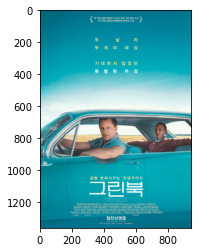

In [44]:
poster = plt.imread('./img/' + str(df_['movie_id'][0]) + '.jpg')
plt.imshow(poster)